In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import podpac
from podpac import Node
from podpac import alglib
import traitlets as tl
import logging
import time
import inspect
logger = logging.getLogger('podpac')
logger.setLevel(logging.DEBUG)

In [3]:
node = podpac.data.Zarr(
#     source='s3://podpac-drought-monitor-s3/SMAP.zarr',
    source=r'C:\SMAP.zarr',
    time_key='time',
    data_key='/Soil_Moisture_Retrieval_Data_AM/soil_moisture',
    lat_key='lat',
    lon_key='lon',
    nan_vals=[-9999]
)
node

Zarr DataSource
	interpolation: nearest

In [4]:
node_poros = podpac.data.Zarr(
#     source='s3://podpac-drought-monitor-s3/SMAP.zarr',
    source=r'C:\SMAP_PROPS.zarr',
    data_key='/Land-Model-Constants_Data/clsm_poros',
    lat_key='lat',
    lon_key='lon',
    nan_vals=[-9999]
)
node_poros

Zarr DataSource
	interpolation: nearest

In [5]:
node.native_coordinates

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[-84.65642547607422, 84.65641784667969], N[1624], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-179.95314025878906, 179.95314025878906], N[3856], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']

DEBUG:podpac.core.data.datasource:Evaluating Zarr data source


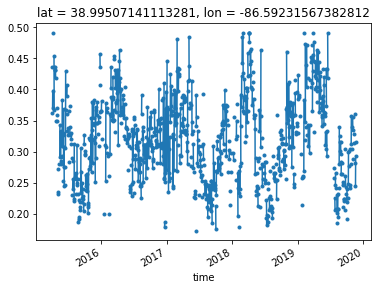

In [6]:
o = node.eval(node.native_coordinates[300, 1000, :])
o[:, :, :].plot(marker='.')

In [7]:
coords = node.native_coordinates[300:302, 1000:1002, :]
coords

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.90475845336914, 38.99507141113281], N[2], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.49898529052734], N[2], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']

In [8]:
sb = alglib.climatology.BetaFitDayOfYear(source=node, percentiles=[0.3, 0.2, 0.1, 0.05, 0.02], window=44, scale_max=node_poros,
                                         scale_float=[0, 1])

In [9]:
s = time.time()
o3 = sb.eval(coords)
tot_time = time.time() - s
print("took {}".format(tot_time))

DEBUG:podpac.core.data.datasource:Evaluating Zarr data source
DEBUG:podpac.core.data.datasource:Evaluating Zarr data source
DEBUG:podpac.core.algorithm.stats:scale_min: 0
scale_max: <xarray.UnitsDataArray (lat: 2, lon: 2)>
array([[0.46200001, 0.4508    ],
       [0.46200001, 0.46200001]])
Coordinates:
  * lat      (lat) float64 39.0 38.9
  * lon      (lon) float64 -86.59 -86.5
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x000001622E8AB888>
    crs:          EPSG:4326
c:\repositories\pipeline\podpac\podpac\core\algorithm\stats.py:1020: RuntimeWarning: invalid value encountered in less_equal
  source.data[(source.data <= 0) | (source.data >= 1)] = np.nan
c:\repositories\pipeline\podpac\podpac\core\algorithm\stats.py:1020: RuntimeWarning: invalid value encountered in greater_equal
  source.data[(source.data <= 0) | (source.data >= 1)] = np.nan
DEBUG:podpac.core.algorithm.stats:Working on doy 1 (1/366)
DEBUG:podpac.core.algorithm.stats:Working on doy 2 (2/366)
DEBUG:po

took 17.276146173477173


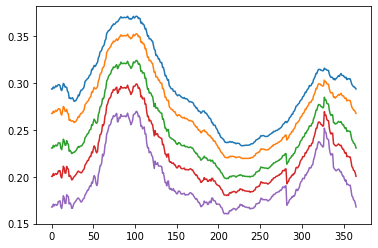

In [10]:
plot((o3)[0, 0, :, 2:].data)

In [11]:
# Decide chunk size based on 20,000 workers and 30% land cover on earth
chunk_size = np.floor(np.sqrt((node.native_coordinates.shape[0] * node.native_coordinates.shape[1] * 0.3)  // 20000))
chunk_size

9.0

In [12]:
9*9*tot_time/4/60  # Expected time to completion in minutes

5.830699333548546

In [13]:
coords['time'].size

1759

In [14]:
node_p = podpac.managers.Process(source=sb)
# node_p = podpac.managers.Lambda(source=sb)
node_mp = podpac.managers.ParallelOutputZarr(
    source=node_p, 
    number_of_workers=4, 
#     number_of_workers=1000, 
    chunks={'lat': 2, 'lon': 2},
    zarr_file=r'C:\SMAP_CATS.zarr', init_file_mode='a',
    zarr_chunks={'lat': 64, 'lon': 64, 'time': 128},
    zarr_shape={'lat': node.native_coordinates['lat'].size, 'lon': node.native_coordinates['lon'].size, 'time': 366},
    zarr_coordinates=podpac.Coordinates([podpac.crange(1, 366, 1, 'time')])
)

In [15]:
o = node_p.eval(coords)

DEBUG:podpac.core.managers.multi_process:Starting process.
DEBUG:podpac.core.managers.multi_process:Retrieving data from queue.
DEBUG:podpac.core.managers.multi_process:Joining.
DEBUG:podpac.core.managers.multi_process:Closing.


In [16]:
# output = dict(format='zarr_part', 
#               format_kwargs=dict(part=[[0, 2, 1], [0, 2, 1], [0, 366, 1]],
#              source=node_mp.zarr_file,mode="a"))
# o.to_format(output['format'], **output['format_kwargs'])

In [17]:
coords_mp = node.native_coordinates[300:304, 1000:1004, :]
coords_mp

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.72446060180664, 38.99507141113281], N[4], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.31224822998047], N[4], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']

In [18]:
o_mp = node_mp.eval(coords_mp)

DEBUG:podpac.core.managers.parallel:Creating Zarr file.
DEBUG:podpac.core.managers.parallel:Starting parallel eval.
DEBUG:podpac.core.managers.parallel:Node eval with coords: (slice(0, 2, None), slice(0, 2, None), slice(0, 1759, None)), Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.90475845336914, 38.99507141113281], N[2], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.49898529052734], N[2], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']
DEBUG:podpac.core.managers.parallel:Node eval with coords: (slice(0, 2, None), slice(2, 4, None), slice(0, 1759, None)), Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.90475845336914, 38.99507141113281], N[2], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.40560913085938, -86.31224822998047], N[2], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']
DEBUG:po

In [19]:
# Check the results
cats = podpac.data.Zarr(
#     source='s3://podpac-drought-monitor-s3/SMAP.zarr',
    source=r'C:\SMAP_CATS.zarr',
)
cats

Zarr DataSource
	interpolation: nearest

In [20]:
d0 = cats.dataset['d0'][:4, :4, :]

In [21]:
cats.dataset['d0'].shape

(1624, 3856, 366)

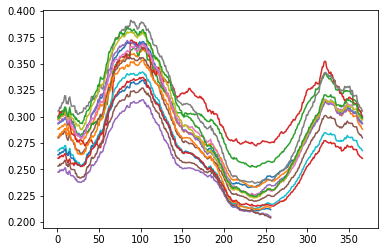

In [22]:
plot(cats.dataset['time'], d0.reshape(-1, 366).T)
pass

In [23]:
list(cats.dataset.keys())

['a', 'b', 'd0', 'd1', 'd2', 'd3', 'd4', 'lat', 'lon', 'time']

In [24]:
cats.native_coordinates

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.72446060180664, 38.99507141113281], N[4], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.31224822998047], N[4], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[1.0, 366.0], N[366], ctype['midpoint']